# EWMA variance

A method for tracking variance over time while giving more importance to recent observations using an exponential decay factor.  

### **Key Ideas**  
- Recent data matters more than older data.  
- Fading factor ( $\alpha$ ) determines how fast older data is "forgotten".
- Variance is updated based on the deviation between the current and previous values.  

### **Mathematical Formulation**  
For a sequence of observations ( $x_t$ ) and initial $weight\_sum = 1$:  

1. **Exponentially Weighted Mean (EWA):**  
   $$
   \text{weight} = (1 - \alpha) \cdot \text{weight\_sum}
   $$
   $$
   \mu_t = \frac{\text{weight} \cdot \mu_{t-1} + x_t}{\text{weight} + 1}
   $$
   where ( $\mu_t$ ) is the exponentially weighted average.  

2. **Exponentially Weighted Variance (EWV):**  
   $$
   \sigma^2_t = \frac{\text{weight} \cdot \sigma^2_{t-1} + (x_t - \mu_{t-1}) (x_t - \mu_t)}{\text{weight} + 1}
   $$
   where ( $\sigma^2_t$ ) is the exponentially weighted variance.  

# Probabilistic Forecasting

Probabilistic forecasting provides **a distribution of possible future values** rather than a single point estimate, allowing for uncertainty quantification. Instead of predicting only the most likely outcome, it estimates a range of potential outcomes along with their probabilities by outputting a **probability distribution**.

A probabilistic forecast models the conditional probability distribution of a future value $(Y_t)$ given past observations $(\mathcal{H}_{t-1})$. This can be expressed as:  

$$P(Y_t \mid \mathcal{H}_{t-1})$$

where $(\mathcal{H}_{t-1})$ represents the historical data up to time $(t-1)$. Instead of a single prediction $(\hat{Y}_t)$, the model estimates a full probability distribution $(f(Y_t \mid \mathcal{H}_{t-1}))$, which can take different parametric forms, such as a Gaussian:

$$Y_t \mid \mathcal{H}_{t-1} \sim \mathcal{N}(\mu_t, \sigma_t^2)$$

where $(\mu_t)$ is the predicted mean and $(\sigma_t^2)$ represents the uncertainty in the forecast.

Probabilistic forecasting can be handled through various approaches, including **variance forecasters**, **quantile forecasters**, **interval forecasters** or **distribution forecasters**, each capturing uncertainty differently.

In this notebook, we try to forecast the target location by a gaussian density function (or a mixture), the model output follows the form:

```python
{"density": {
                "name": "normal",
                "params": {"loc": y_mean, "scale": y_var}
            },
                "weight": weight
}
```

A **mixture density**, such as the gaussion mixture $\sum_{i=1}^{K} w_i \mathcal{N}(Y_t | \mu_i, \sigma_i^2)$ allows for capturing multi-modal distributions and approximate more complex distributions.

![proba_forecast_v3](https://github.com/Tarandro/image_broad/blob/main/proba_forecast_v3.png?raw=true)


**Probabilistic Forecasting** is particularly valuable in supply chain management. Below are some interesting resources for a deeper understanding:  

- [Probabilistic Forecasting](https://www.lokad.com/probabilistic-forecasting-definition/) – Overview of probabilistic forecasting and its applications.  
- [Quantile Forecasting](https://www.lokad.com/quantile-regression-time-series-definition/) – Explanation of quantile-based forecasting methods.  
- **Evaluation Metrics:**  
  - [Continuous Ranked Probability Score (CRPS)](https://www.lokad.com/continuous-ranked-probability-score/)  
  - [Cross-Entropy](https://www.lokad.com/cross-entropy-definition/)  
  - [Pinball Loss](https://www.lokad.com/pinball-loss-function-definition/)

In [ ]:
# Requirements
!pip install birdgame river --upgrade

In [1]:
# Standard library imports
import os
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from tqdm.auto import tqdm

# Birdgame package imports
from birdgame.trackers.trackerbase import TrackerBase
from birdgame import HORIZON
from birdgame.visualization.viz_fewvar import visualize_fewvar

### Warm up example: FEWVar model

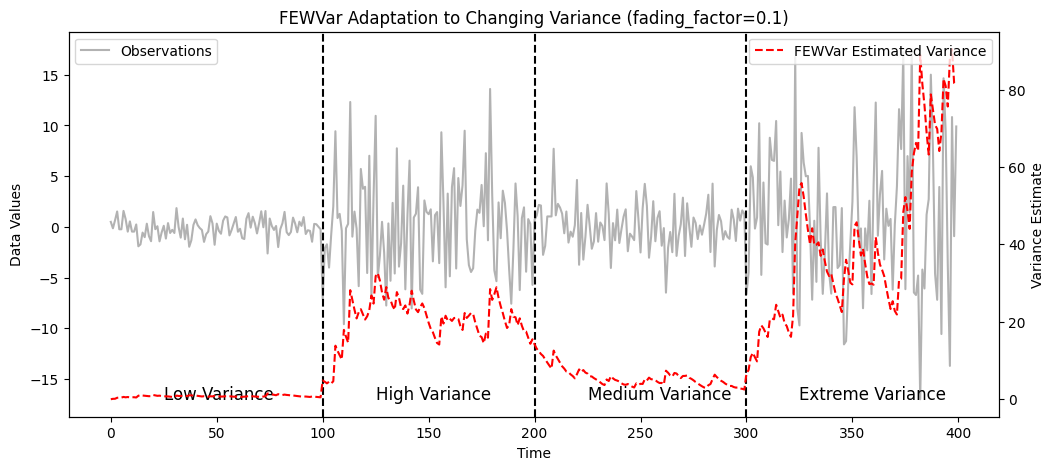

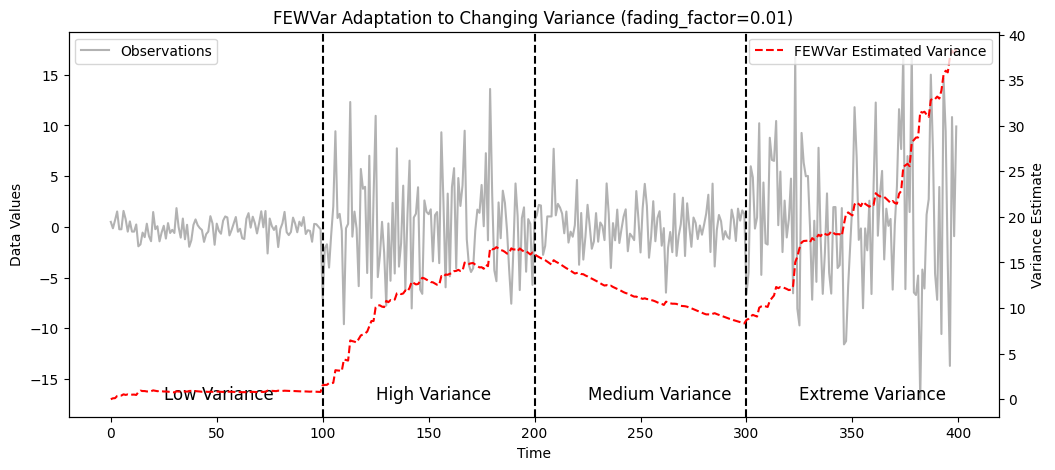

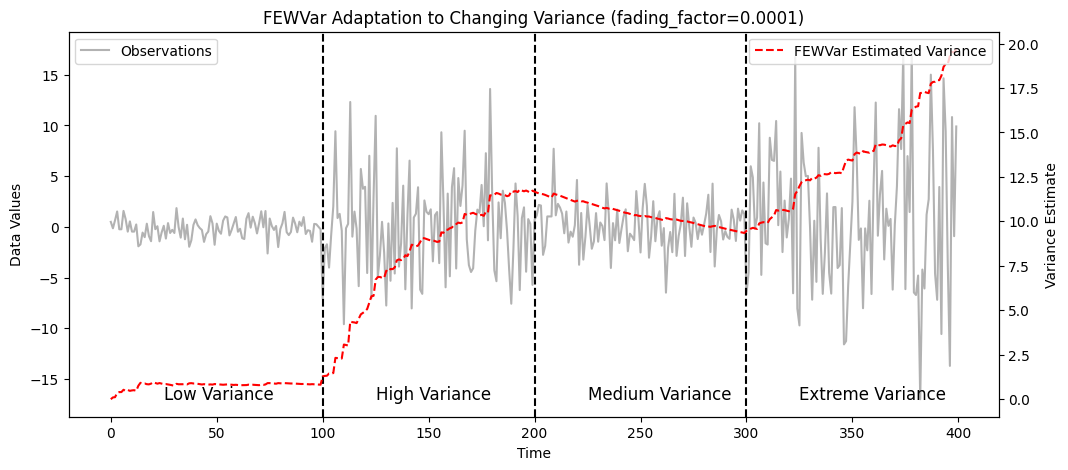

In [2]:
# Visualize FEWVar on synthetic data with different fading_factor values
list_fading_factor = [0.1, 0.01, 0.0001]
for factor in list_fading_factor:
    visualize_fewvar(fading_factor=factor, list_variances=[1, 5, 2, 8])

In [3]:
import math
import numpy as np
from birdgame.stats.fewvar import FEWVar


class EMWAVarTracker(TrackerBase):
    """
    A model that fits a mixture of two Gaussian distributions, one capturing the core
    distribution and another with a larger variance to capture the tails.
    Using EWMA variance

    Parameters
    ----------
    fading_factor : float
        Parameter controlling how quickly older data is de-emphasized in variance estimation.
    horizon : int
        The prediction horizon in seconds (how far into the future predictions should be made).
    warmup : int
        The number of ticks taken to warm up the model (wealth does not change during this period).
    """

    def __init__(self, horizon=HORIZON):
        super().__init__(horizon)
        self.fading_factor = Constants.FADE_FACTOR
        self.current_x = None
        self.ewa_dx_core = FEWVar(fading_factor=self.fading_factor)
        self.ewa_dx_tail = FEWVar(fading_factor=self.fading_factor)
        self.weights = [0.95, 0.05]  # Heavily weight the core distribution

        self.latest_threat = 0.0

        self.warmup_cutoff = Constants.WARMUP_CUTOFF
        self.tick_count = 0

    def tick(self, payload, performance_metrics):
        """
        Ingest a new record (payload), store it internally and update the
        estimated Gaussian mixture model.

        The core distribution captures regular variance, while the tail distribution
        captures extreme deviations.

        Function signature can also look like tick(self, payload) since performance_metrics 
        is an optional parameter.

        Parameters
        ----------
        payload : dict
            Must contain 'time' (int/float) and 'dove_location' (float).
        performance_metrics : dict (is optional)
            Dict containing 'wealth', 'likelihood_ewa', 'recent_likelihood_ewa'
        """

        # # To see the performance metrics on each tick
        # print(f"performance_metrics: {performance_metrics}")

        # # Can trigger a warmup by checking if a performance metric drops below a threshold
        # if performance_metrics['recent_likelihood_ewa'] < 1.1:
        #     self.tick_count = 0

        x = payload['dove_location']
        t = payload['time']
        # falcon_x = payload["falcon_location"]
        # wingspan = payload["falcon_wingspan"]
        self.add_to_quarantine(t, x)
        self.current_x = x
        prev_x = self.pop_from_quarantine(t)

        if prev_x is not None:
            x_change = x - prev_x

            # Winsorize the update for the core estimator to avoid tail effects
            threshold = 2.0 * math.sqrt(self.ewa_dx_core.get() if self.count > 0 else 1.0)
            if threshold > 0:
                winsorized_x_change = np.clip(x_change, -threshold, threshold)
            else:
                winsorized_x_change = x_change
            self.ewa_dx_core.update(winsorized_x_change)

            # Feed the tail estimator with double the real change magnitude
            self.ewa_dx_tail.update(2.0 * x_change)

            self.count += 1

        # # Update threat level: high wingspan + low distance => higher uncertainty
        # dist = abs(falcon_x - x)
        # self.latest_threat = wingspan / (dist + 1e-3)  # Avoid divide-by-zero

        self.tick_count += 1

    def predict(self):
        """
        Return a dictionary representing the best guess of the distribution,
        modeled as a mixture of two Gaussians.

        If the model is in the warmup period, return None.
        """
        # Check if the model is warming up
        if self.tick_count < self.warmup_cutoff:
            return None
            
        # the central value (mean) of the gaussian distribution will be represented by the current value
        x_mean = self.current_x
        components = []

        for i, ewa_dx in enumerate([self.ewa_dx_core, self.ewa_dx_tail]):
            try:
                x_var = ewa_dx.get()
                x_std = math.sqrt(x_var)
            except:
                x_std = 1.0

            if x_std <= 1e-6:
                x_std = 1e-6

            # std = max(std, 1e-6)  # Avoid degenerate std

            # # Scale std based on current threat level (tunable factor 0.2)
            # scaled_std = std * (1.0 + 0.2 * self.latest_threat)

            components.append({
                "density": {
                    "type": "builtin",
                    "name": "norm",
                    "params": {"loc": x_mean, "scale": x_std}
                },
                "weight": self.weights[i]
            })

        prediction_density = {
            "type": "mixture",
            "components": components
        }

        return prediction_density

### Tracker experimentation

The model is experimented on a data generator using the [density_pdf](https://github.com/microprediction/densitypdf/blob/main/densitypdf/__init__.py) scoring. For a gaussian distribution, it is:

$$\text{pdf\_score}(x) = \frac{1}{\sqrt{2\pi\sigma^2}} \cdot e^{-\frac{(x - \mu)^2}{2\sigma^2}}$$

This metric measures how well the predicted distribution aligns with the observed data. **A higher pdf_score indicates a more accurate prediction.**

In [4]:
# Parameters
class Constants:
    FADE_FACTOR = 0.0001
    WARMUP_CUTOFF = 0

### Run on a remote static data file

In [6]:
# Initialize Tracker
tracker = EMWAVarTracker()

# Run on remote data
tracker.test_run(live=False)

0it [00:00, ?it/s]

My log-likelihood score: -11.0849 VS Benchmark log-likelihood score: -11.0849
     .... and mine is worse. Ratio is 1.00000
My log-likelihood score: -3.3915 VS Benchmark log-likelihood score: -3.3915
     .... and mine is worse. Ratio is 1.00000
My log-likelihood score: -2.8604 VS Benchmark log-likelihood score: -2.8604
     .... and mine is worse. Ratio is 1.00000
My log-likelihood score: -2.2542 VS Benchmark log-likelihood score: -2.2542
     .... and mine is worse. Ratio is 1.00000
My log-likelihood score: -1.7795 VS Benchmark log-likelihood score: -1.7795
     .... and mine is worse. Ratio is 1.00000
My log-likelihood score: -1.4862 VS Benchmark log-likelihood score: -1.4862
     .... and mine is worse. Ratio is 1.00000
My log-likelihood score: -1.2124 VS Benchmark log-likelihood score: -1.2124
     .... and mine is worse. Ratio is 1.00000
My log-likelihood score: -0.9781 VS Benchmark log-likelihood score: -0.9781
     .... and mine is worse. Ratio is 1.00000
My log-likelihood scor

### Run on live data

In [7]:
# Initialize Tracker
tracker = EMWAVarTracker()

# Run on live data
tracker.test_run(live=True)
# Interrupt cell to stop run

0it [00:00, ?it/s]

My log-likelihood score: -3.2935 VS Benchmark log-likelihood score: -3.2935
     .... and mine is worse. Ratio is 1.00000
Interrupted


### An animated run

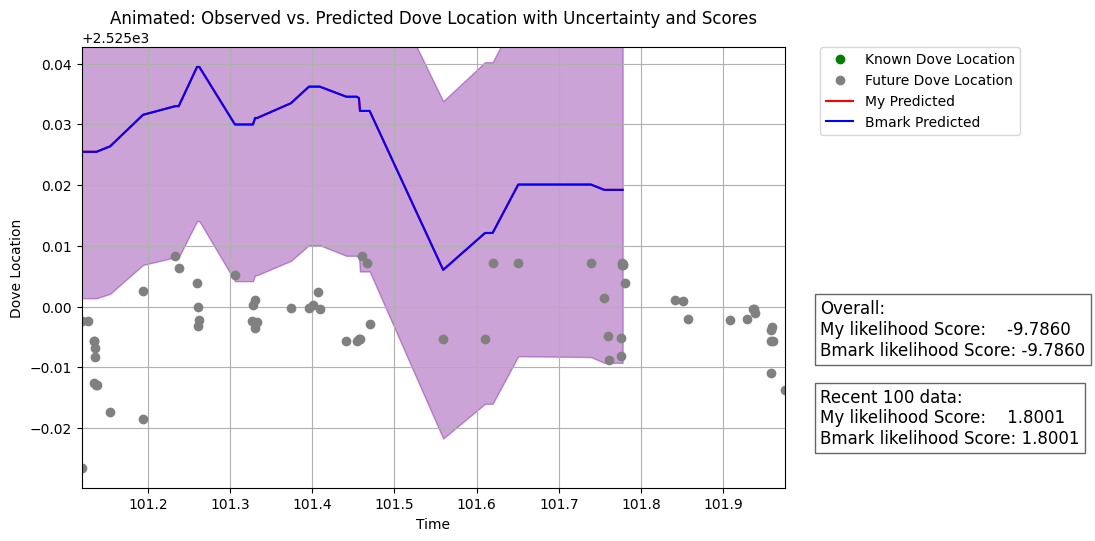


 Run stopped by user.


In [11]:
%matplotlib inline
from IPython.display import HTML

tracker = EMWAVarTracker()

# Note: the model has a warmup period
try:
    animated = tracker.test_run_animated(live=False, from_notebook=True)

    # Display animation in notebook
    HTML(animated.to_jshtml())
except KeyboardInterrupt:
    print("\n Run stopped by user.")
# Interrupt cell to stop run

### Design your own testing process and statistical analysis

In [15]:
from birdgame.model_benchmark.emwavartracker import EMWAVarTracker
from birdgame.trackers.tracker_evaluator import TrackerEvaluator
from birdgame.datasources.livedata import live_data_generator
from birdgame.datasources.remotetestdata import remote_test_data_generator
from birdgame.visualization.utils import get_loc_and_scale


live = False
step_print = 1000
warmup_iterations = 1000
max_iterations = 10000

tracker = EMWAVarTracker()

benchmark_tracker = EMWAVarTracker(horizon=tracker.horizon)
my_run, bmark_run = TrackerEvaluator(tracker), TrackerEvaluator(benchmark_tracker)

gen = live_data_generator() if live else remote_test_data_generator()

store_pred = []
try:
    for i, payload in enumerate(tqdm(gen)):

        my_run.tick_and_predict(payload)
        bmark_run.tick_and_predict(payload)

        if i > warmup_iterations:
            score = my_run.scores[-1]
            
            loc, scale = get_loc_and_scale(my_run.latest_valid_prediction)
            store_pred.append({
                "time": my_run.time,
                "prediction": my_run.latest_valid_prediction,
                "loc": loc,
                "scale": scale,
                "dove_location": my_run.dove_location,
                "score": score,
                "log_score": np.log(1e-10 + score)
            })

        if (i + 1) % step_print == 0:
            print(f"My likelihood score: {my_run.overall_likelihood_score():.4f} VS Benchmark likelihood score: {bmark_run.overall_likelihood_score():.4f}")

        if i > max_iterations:
            break

    print(f"My likelihood score: {my_run.overall_likelihood_score():.4f} VS Benchmark likelihood score: {bmark_run.overall_likelihood_score():.4f}")
except KeyboardInterrupt:
    print("Interrupted")

0it [00:00, ?it/s]

My likelihood score: -11.0849 VS Benchmark likelihood score: -11.0849
My likelihood score: -3.3915 VS Benchmark likelihood score: -3.3915
My likelihood score: -2.8604 VS Benchmark likelihood score: -2.8604
My likelihood score: -2.2542 VS Benchmark likelihood score: -2.2542
My likelihood score: -1.7795 VS Benchmark likelihood score: -1.7795
My likelihood score: -1.4862 VS Benchmark likelihood score: -1.4862
My likelihood score: -1.2124 VS Benchmark likelihood score: -1.2124
My likelihood score: -0.9781 VS Benchmark likelihood score: -0.9781
My likelihood score: -0.7381 VS Benchmark likelihood score: -0.7381
My likelihood score: -0.5376 VS Benchmark likelihood score: -0.5376
My likelihood score: -0.5373 VS Benchmark likelihood score: -0.5373


In [16]:
from birdgame.visualization.utils import summarize_predictions
stats_summary, pred_summary = summarize_predictions(store_pred, skip_length=0)

Mean: {'score': 2.938, 'log_score': 0.263}
Median: {'score': 2.976, 'log_score': 1.091}
Std: {'score': 2.721, 'log_score': 1.719}

Prediction Data:


,time,prediction,loc,scale,dove_location,score,log_score
0,100.65945,"{'type': 'mixture', 'components': [{'density':...",2525.02935,0.02216,2525.02132,16.10574,2.77918
1,100.66073,"{'type': 'mixture', 'components': [{'density':...",2525.02935,0.02216,2525.02046,15.86834,2.76433
2,100.66264,"{'type': 'mixture', 'components': [{'density':...",2525.02935,0.02216,2525.01520,14.03940,2.64187
3,100.66550,"{'type': 'mixture', 'components': [{'density':...",2525.02935,0.02216,2525.01056,12.02899,2.48732
4,100.67378,"{'type': 'mixture', 'components': [{'density':...",2525.03438,0.02226,2525.00239,6.15243,1.81685
...,...,...,...,...,...,...,...
8996,192.45907,"{'type': 'mixture', 'components': [{'density':...",2524.41795,0.09640,2524.35344,3.21616,1.16819
8997,192.46193,"{'type': 'mixture', 'components': [{'density':...",2524.41795,0.09640,2524.36404,3.43630,1.23440
8998,192.47212,"{'type': 'mixture', 'components': [{'density':...",2524.41751,0.09640,2524.37014,3.55871,1.26940
8999,192.50841,"{'type': 'mixture', 'components': [{'density':...",2524.40318,0.09636,2524.36646,3.73250,1.31708


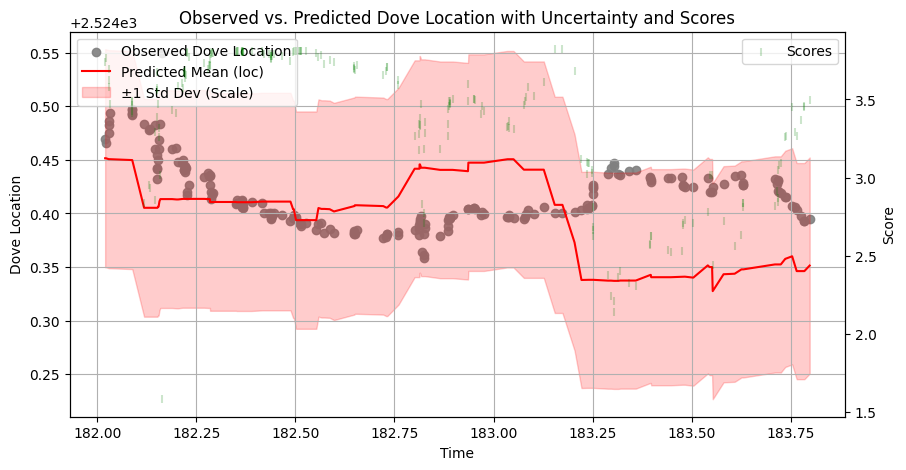

In [17]:
from birdgame.visualization.viz_predictions import plot_dove_predictions
start_ind=8000
window_size=200
plot_dove_predictions(store_pred, start_ind, window_size)